# Project 3

I have analysed and tested the data before. Now, I want to try importing a data set on GHG levels in the atmosphere, and temperatures, and use these in the feature matrix together with the em-dat features. I think, in order to make predictions, something like this will have to be done:

## Option 1
- Train with all features
- Create a sub-model for prediction, where I extract the weights and biases for the features I wish to use in prediction

## Option 2
- Train only on the features to be used in prediction

## Use random forests or whatever (2 steps from lectures)
I need to use enough of whatever methods are mentioned in lectures
- One option is to compare neural net to random forests (apparently good for tabular data??)

### TODO:
- Cost needs to be adjusted for inflation before anything else is done
- Add co2 and/or temp if I can be bothered. Need to match year and place with the disaster data 


## Solution

Set up data holder class:

In [82]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import namedtuple

# Create data class
class data_holder():
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.df = self.data.copy()

    def filter_columns(self, columns_to_keep):
        self.data = self.data[columns_to_keep]

    def remove_rows_where_null(self, remove_null_rows_in_column):
        self.data = self.data.dropna(subset = remove_null_rows_in_column)

    def replace_nan_with_zero(self, replace_nan_in_columns):
        self.data[replace_nan_in_columns] = self.data[replace_nan_in_columns].fillna(0)

    def filter_values(self, column, values):
        self.data = self.data[self.data[column].isin(values)]

    def map_categories_to_numbers(self, column):
        label_encoder = LabelEncoder()

        self.data[column] = label_encoder.fit_transform(self.data[column])
        category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
        print("Category Mapping:", category_mapping)

    def split_train_test(self, target_column):
        self.target = target_column
        feature_columns = self.data.columns.drop([target_column])

        self.X = self.data[feature_columns]
        self.y = self.data[target_column]

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y , random_state=104,test_size=0.20, shuffle=True)

        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def scale(self, scaler):
        # if self.target is None:
        #     raise ValueError("Target column needs to be set in split_train_test() before scaling data")

        # X = self.data.drop(columns=[self.target])  # Features
        # y = self.data[self.target]  # Target

        # Training set
        X_train_scaled = scaler.fit_transform(self.X_train)
        y_train_scaled = scaler.fit_transform(self.y_train.values.reshape(-1, 1))

        # Test set
        X_test_scaled = scaler.fit_transform(self.X_test)
        y_test_scaled = scaler.fit_transform(self.y_test.values.reshape(-1, 1))

        #From chatgpt:
        # Optional: Convert back to DataFrame for easier handling (if needed)
        # X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

        # # Recombine scaled features with the target for further processing
        # scaled_data = pd.concat([X_scaled_df, y.reset_index(drop=True)], axis=1)

        return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled

        


Then clean the data:

In [83]:
disasters = data_holder('./DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv')

columns_of_interest = [ "Year", "Aid Contribution", "No Injured", "No Homeless", "Total Affected", "CPI", "Total Damages ('000 US$)", "Disaster Subgroup", "Insured Damages ('000 US$)"]
zero_where_null_columns = ["Aid Contribution", "No Injured", "No Homeless", "Total Affected", "Disaster Subgroup"]
remove_where_null_columns = ["CPI", "Total Damages ('000 US$)", "Insured Damages ('000 US$)"]
disaster_subgroups = [ "Meteorological", "Hydrological", "Climatological"]

#Clean data
disasters.filter_columns(columns_of_interest)
disasters.remove_rows_where_null(remove_where_null_columns)

disasters.replace_nan_with_zero(zero_where_null_columns)

disasters.filter_values('Disaster Subgroup', disaster_subgroups)

#Turn category-values into numerical values
disasters.map_categories_to_numbers("Disaster Subgroup")

Category Mapping: {'Climatological': 0, 'Hydrological': 1, 'Meteorological': 2}


Get the shape of the feature matrix to prepare for model input:

In [50]:
print("Shape of data set after cleaning:")
print(disasters.data.shape)

disasters.data.head()

Shape of data set after cleaning:
(808, 9)


,Year,Aid Contribution,No Injured,No Homeless,Total Affected,CPI,Total Damages ('000 US$),Disaster Subgroup,Insured Damages ('000 US$)
2300,1984,0.0,250.0,0.0,250.0,40.138660,950000.0,2,480000.0
2364,1985,0.0,0.0,0.0,0.0,41.561827,122000.0,2,68400.0
2387,1985,0.0,200.0,800.0,1000.0,41.561827,117000.0,2,89500.0
2423,1985,0.0,0.0,0.0,100000.0,41.561827,73000.0,2,68400.0
2462,1986,0.0,0.0,0.0,0.0,42.350699,105000.0,2,82300.0


Add temperature data (from: https://climate.nasa.gov/vital-signs/global-temperature/?intent=121):

In [98]:
# Load data
temp = data_holder('./Climate/temperatureAnomalies.csv')
df = temp.df

global_temp_df = df[df['Year'] >= 1900]
global_temp_df = global_temp_df[global_temp_df['Year'] <= 2021]

,Year,No_Smoothing,Lowess(5)
0,1880,-0.18,-0.10
1,1881,-0.09,-0.14
2,1882,-0.11,-0.17
3,1883,-0.18,-0.21
4,1884,-0.28,-0.24


In [97]:
# Reset index to turn 'Year' into a regular column
temp_df = global_temp_df.reset_index()
temp_df.head()

# Merge on 'Year'
combined_df = pd.merge(temp_df, disasters.data, on='Year', how='inner')

In [88]:
print(combined_df.shape)
combined_df.head()

(808, 12)


,index,Year,No_Smoothing,Lowess(5),Aid Contribution,No Injured,No Homeless,Total Affected,CPI,Total Damages ('000 US$),Disaster Subgroup,Insured Damages ('000 US$)
0,104,1984,0.16,0.21,0.0,250.0,0.0,250.0,40.138660,950000.0,2,480000.0
1,104,1984,0.16,0.21,0.0,0.0,0.0,0.0,40.138660,600000.0,2,280000.0
2,105,1985,0.12,0.22,0.0,0.0,0.0,0.0,41.561827,122000.0,2,68400.0
3,105,1985,0.12,0.22,0.0,200.0,800.0,1000.0,41.561827,117000.0,2,89500.0
4,105,1985,0.12,0.22,0.0,0.0,0.0,100000.0,41.561827,73000.0,2,68400.0


Split into training and test data:

In [89]:
target = "Total Damages ('000 US$)"
X_train, X_test, y_train, y_test = disasters.split_train_test(target)

In [ ]:
# Check the data types of X_train and X_test
print("Data types of X_train columns:")
print(X_train.dtypes)
print()

print("Data types of X_test columns:")
print(X_test.dtypes)

Scale the data:

In [90]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = disasters.scale(scaler)

Create tensors:

In [91]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).reshape(-1, 1)

Create model:

In [92]:
# Define the model - for now, the input has 44 feature columns
model = nn.Sequential(
    nn.Linear(8, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train model:

In [93]:
#From https://machinelearningmastery.com/building-a-regression-model-in-pytorch/
import numpy as np
import torch
import tqdm
import copy
from sklearn.model_selection import train_test_split

# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_tensor), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test_tensor)
    mse = loss_fn(y_pred, y_test_tensor)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

Some graphs to show results:

MSE: 0.25
RMSE: 0.50


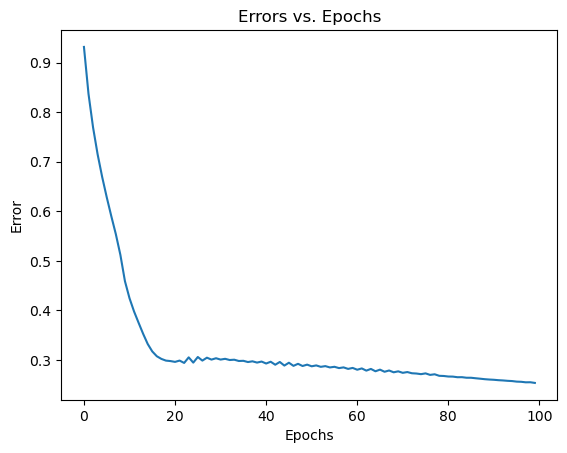

In [94]:
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.title("Errors vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.plot(history)
plt.show()

Mean Squared Error on Test Data: 0.25355759263038635
R-squared on Test Data: 0.746442437171936


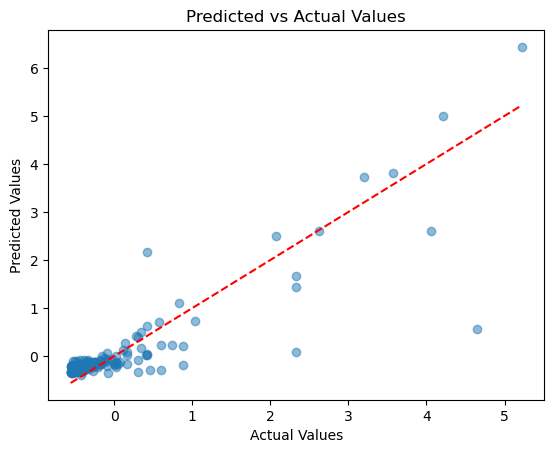

In [95]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    y_test_pred = model(X_test_tensor)

mse = loss_fn(y_test_pred, y_test_tensor)
print(f"Mean Squared Error on Test Data: {mse.item()}")

ss_total = torch.sum((y_test_tensor - torch.mean(y_test_tensor))**2)
ss_residual = torch.sum((y_test_tensor - y_test_pred)**2)
r_squared = 1 - (ss_residual / ss_total)
print(f"R-squared on Test Data: {r_squared.item()}")

import matplotlib.pyplot as plt

# Convert tensors to numpy arrays for plotting
y_test_actual = y_test_tensor.numpy()
y_test_pred_np = y_test_pred.numpy()

plt.scatter(y_test_actual, y_test_pred_np, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

